# Imports

In [1]:
import pandas as pd
# import numpy as np
from scipy import stats
from distfit import distfit
from datetime import datetime, timedelta
import altair as alt
import matplotlib.pyplot as plt
# import seaborn as sns

# Functions  

I will define some functions to avoid repetation in the code.

In [2]:
def change_datetime_zone(df):
    df = datetime.strptime(df, "%Y-%m-%d %H:%M:%S")
    hour_diff = timedelta(hours=3)
    df = df + hour_diff
    return df

def raw_date_to_datetime(raw_date):
    datetime_dict = dict()  # New row to replace
    datetime_dict["Date"] = raw_date  # Get the date in the format "DD.MM.YYYY"
    # datetime_dict["Time"] = raw_date.strftime("%H:%M")  # Get the time in format "HH:MM"
    datetime_dict["MonthName"] = raw_date.strftime("%B")  # Get the full month name
    datetime_dict["DayName"] = raw_date.strftime("%A")  # Get the full day name

    return datetime_dict

def ceil_dt(dt, delta):
    dt_min = datetime.min.replace(tzinfo=dt.tzinfo)
    return dt + (dt_min - dt) % delta

def floor_dt(dt, delta):
    replace = (dt.minute // delta) * delta
    return dt.replace(minute=replace)

def dt_to_min(dt):
    if type(dt) == str:
        hour, minute = map(int, dt.split(":"))
        return hour * 60 + minute
    
    return dt.hour * 60 + dt.minute    

def is_subscribed_to(subreddit_name, subscribed_subs_df):
    if (subscribed_subs_df == subreddit_name).any().any():
        return 1
    return 0

# Data Collecting

Get the data from the .csv files, clear and format a bit to get useful pandas DataFrames.  

## Different Data
* Subscribed Subreddits
* IP Logs
* Post Votes
* Comment Votes
* Posts
* Comments

In [3]:
# Data path
data_path = "./data/scrapped_data/"
backup_data_path = "./data/raw_data/"

## Subscribed Subreddits

This data holds the subreddits that I am _currently_ subscribed to. It does not hold a history or any temporal data.  

Reddit subreddits doesn't include direct a way to _categorize_ them by some kind of a tag or topic system execpt a list of _"flairs"_ that can be used to label posts in that subreddit. However, to better analyse them a tag system might be useful. I will use a google form to ask people to annotate the subreddits and use that data to categorize them.
This data file also includes followed users (not subs). They are marked with a 'u_' prefix in the data. They will be filtered, but saved anyway since they might be useful in the future.

In [4]:
# Read the file, sort by name of the subreddits and reset the index after sorting
sub_fname = "subscribed_subreddits.csv"
subreddits_df = pd.read_csv(data_path + sub_fname).sort_values(by="subreddit").reset_index().drop(columns="index")

followed_users_df = subreddits_df[subreddits_df["subreddit"].str.contains("u_")]
subreddits_df = subreddits_df[~subreddits_df["subreddit"].str.contains("u_")]
# subreddits_df.to_csv(data_path + sub_fname, index=False)
subreddits_df

,subreddit,Flairs,Tags
0,AskScienceFiction,NaN,"hobby, information/question"
1,CodeBullet,"meme, question for codebullet, video idea, oth...","fandom, meme, programming"
2,DMAcademy,"offering advice, need advice: encounters & adv...","hobby, information/question"
3,DaystromInstitute,NaN,"movie/show, fandom"
4,Deepspaceninememes,"original content [oc], shitpost","meme, movie/show, fandom"
5,ElectroBOOM,"faf - rectify, electroboom question, non-elect...","fandom, hobby, meme"
6,ExposurePorn,NaN,hobby
7,FATErpg,NaN,"information/question, hobby"
8,GeekyaparLamers,NaN,"fandom, meme"
9,GreekMythology,"discussion, question, art, culture, history, i...","hobby, information/question"


## IP Logs

IP logs data holds information about my logins to Reddit. It holds the datetime and the IP that I used. This data might be used on showing my active times even though it doesn't hold information on how long I have stayed active.  

The date data is in the form of "yyyy-mm-dd hh:mm:ss UTC". I will convert time into GMT+3, and name the months and days.

In [5]:
# Read the file, drop the first row that holds the registiration IP only, drop the IP column and reset the indexing
logs_fname = "ip_logs.csv"
login_datetime_df = pd.read_csv(backup_data_path + logs_fname).rename(columns={"date": "RawDate"}).drop(index=0, columns="ip").reset_index().drop(columns="index")

try:
    raw_date_col = login_datetime_df["RawDate"]  # Raw Date column

    # Add new columns
    login_datetime_df[["Date", "MonthName", "DayName"]] = None
    
    for idx in range(len(raw_date_col)):
        raw_date = raw_date_col.iloc[idx].replace(" UTC", "")  # Get the time in UTC time
    
        # Convert datetime to local time zone
        local_datetime = change_datetime_zone(raw_date)
        datetime_dict = raw_date_to_datetime(local_datetime)

        # Insert items from datetime_dict to the new columns
        for key in datetime_dict:
            login_datetime_df.loc[idx, key] = datetime_dict[key]

    login_datetime_df = login_datetime_df.drop(columns="RawDate")
except KeyError:
    pass

login_datetime_df["Date"] = pd.to_datetime(login_datetime_df["Date"])
# login_datetime_df.to_csv(data_path + logs_fname, index=False)
login_datetime_df

,Date,MonthName,DayName
0,2023-06-29 13:16:07,June,Thursday
1,2023-06-29 17:25:25,June,Thursday
2,2023-06-30 04:16:29,June,Friday
3,2023-06-30 07:15:35,June,Friday
4,2023-06-30 08:46:19,June,Friday
...,...,...,...
357,2023-10-06 15:19:55,October,Friday
358,2023-10-06 16:40:52,October,Friday
359,2023-10-06 18:16:58,October,Friday
360,2023-10-07 11:04:02,October,Saturday


## Post Votes

This data includes the posts that I have voted. It includes an ID, the post link, and the type of the vote and through Reddit API it includes the total number of upvotes and downvotes, and the flair; however, no temporal data.  

I will get the subreddit name from the URL, my vote and I will compare the sub to the subscribed subs data and get wheter or not I am subscribed to that subreddit currently.  

Also, note that some of the posts are inaccesible due to different reasons which prevents data collection through Reddit API; therefore, there are some missing values in the data.

In [6]:
# Read the file, rename the vote direction column and drop the id column.
post_votes_fname = "post_votes.csv"
post_votes_df = pd.read_csv(data_path + post_votes_fname).rename(columns={"direction": "MyVote", "Upvotes": "UpvoteCount", "Downvotes": "DownvoteCount"}).drop(columns="id")

# Convert vote direction to a quantitative value
post_votes_df["MyVote"] = post_votes_df["MyVote"].map({"up": 1, "down": -1})

# Add the new columns
post_votes_df[["SubredditName", "IsSubscribed"]] = None

for idx in range(len(post_votes_df["permalink"])):
    post_vote_dict = {"SubredditName": None, "IsSubscribed": None}
        
    # Get the sub name from the link
    permalink = post_votes_df.loc[idx, "permalink"]
    start_idx = permalink.find("r/") + 2
    stop_idx = permalink.find("/", start_idx)
    sub_name = permalink[start_idx:stop_idx]
    
    # Add sub name to the corresponding place
    post_votes_df.loc[idx, "SubredditName"] = sub_name

    # Check if the sub is subscribed
    post_votes_df.loc[idx, "IsSubscribed"] = is_subscribed_to(sub_name, subreddits_df)

# Drop the permalink column
post_votes_df = post_votes_df.drop(columns="permalink")
# Specify the Dtypes for later use
post_votes_df["IsSubscribed"] = post_votes_df["IsSubscribed"].astype(dtype="bool")
# post_votes_df.to_csv(data_path + post_votes_fname, index=False)
post_votes_df

,MyVote,UpvoteCount,DownvoteCount,Flair,SubredditName,IsSubscribed
0,1.0,NaN,NaN,NaN,unexpectedMontyPython,True
1,1.0,198.0,3.0,meme,ProgrammerHumor,True
2,1.0,11978.0,902.0,meme,TheLastAirbender,True
3,1.0,158.0,9.0,NaN,risa,True
4,1.0,NaN,NaN,NaN,unexpectedMontyPython,True
...,...,...,...,...,...,...
1217,1.0,9443.0,711.0,NaN,gaming,True
1218,NaN,10.0,0.0,NaN,ProgrammerHumor,True
1219,1.0,7.0,2.0,NaN,seinfeld,True
1220,1.0,182.0,6.0,meme,ProgrammerHumor,True


## Comment Votes  

Comment votes is almost identical to the post votes data except that this includes the information about comments that I have voted instead of posts. Also through Reddit API it holds the score (or the net number of upvotes) instead of seperate counts of upvotes and downvotes.  

I will perform the same cleaning as the post votes data: Remove the ID, get the subreddit name from the URL, my vote and I will compare the sub to the subscribed subs data and get wheter or not I am subscribed to that subreddit currently.  

Also, note that some of the comments or their posts are inaccesible due to different reasons which prevents data collection through Reddit API; therefore, there are some missing values in the data.

In [7]:
# Read the file, rename the vote direction column and drop the id column.
comment_votes_fname = "comment_votes.csv"
comment_votes_df = pd.read_csv(data_path + comment_votes_fname).rename(columns={"direction": "MyVote"}).drop(columns="id")

# Convert vote direction to a quantitative value
comment_votes_df["MyVote"] = comment_votes_df["MyVote"].map({"up": 1, "down": -1})

# Add the new columns
comment_votes_df[["SubredditName", "IsSubscribed"]] = None

for idx in range(len(comment_votes_df["permalink"])):
    comment_vote_dict = {"SubredditName": None, "IsSubscribed": None}
        
    # Get the sub name from the link
    permalink = comment_votes_df.loc[idx, "permalink"]
    start_idx = permalink.find("r/") + 2
    stop_idx = permalink.find("/", start_idx)
    sub_name = permalink[start_idx:stop_idx]

    # Add sub name to the corresponding place
    comment_votes_df.loc[idx, "SubredditName"] = sub_name

    # Check if the sub is subscribed
    comment_votes_df.loc[idx, "IsSubscribed"] = is_subscribed_to(sub_name, subreddits_df)

# Drop the permalink column
comment_votes_df = comment_votes_df.drop(columns="permalink")
# Specify the Dtypes for later use
comment_votes_df["IsSubscribed"] = comment_votes_df["IsSubscribed"].astype(dtype="bool")
# comment_votes_df.to_csv(data_path + comment_votes_fname, index=False)
comment_votes_df

,MyVote,Score,SubredditName,IsSubscribed
0,1.0,2.0,GenP,False
1,1.0,1.0,flashcarts,False
2,1.0,1185.0,ProgrammerHumor,True
3,1.0,197.0,startrek,True
4,1.0,3.0,startrek,True
...,...,...,...,...
255,1.0,36.0,CodeBullet,True
256,1.0,1.0,montypython,True
257,NaN,38.0,seinfeld,True
258,1.0,13.0,TheLastAirbender,True


## Posts  

The posts data is about the posts that I have created. It includes an ID, a permalink to the post, posting date, the IP that I have used, subreddit name that the post has been posted, and gildings and url data. Also the number of upvotes and downvotes, and the flair through Reddit API.  

I will drop the permalink, IP, gildings, url and check if I am subscribed to the sub I have posted. I will keep the IDs to compare with the comments data later on.

Also, note that some of the posts are inaccesible due to different reasons which prevents data collection through Reddit API; therefore, there are some missing values in the data.

In [8]:
# Read the file, rename the id, date, and subreddit columns and drop the permalink, ip, gildings, and url columns.
posts_fname = "post_headers.csv"
posts_df = pd.read_csv(data_path + posts_fname).rename(columns={"id": "ID", "date": "RawDate", "subreddit": "Subreddit"}).drop(columns=["permalink", "ip", "gildings", "url"])

try:
    raw_date_col = posts_df["RawDate"]  # Raw Date column

    # Add new columns
    posts_df[["IsSubscribed", "Date", "MonthName", "DayName"]] = None
    
    for idx in range(len(raw_date_col)):
        raw_date = raw_date_col.iloc[idx].replace(" UTC", "")  # Get the time in UTC time
    
        # Convert datetime to local time zone
        local_datetime = change_datetime_zone(raw_date)
        datetime_dict = raw_date_to_datetime(local_datetime)

        # Insert items from datetime_dict to the new columns
        for key in datetime_dict:
            posts_df.loc[idx, key] = datetime_dict[key]
        
        # Check if subscribed
        posts_df.loc[idx, "IsSubscribed"] = is_subscribed_to(posts_df.loc[idx, "Subreddit"], subreddits_df)
    
    posts_df = posts_df.drop(columns="RawDate")
except KeyError:
    pass

# Specify the Dtypes for later use
posts_df["IsSubscribed"] = posts_df["IsSubscribed"].astype(dtype="bool")
posts_df["Date"] = pd.to_datetime(posts_df["Date"])
# posts_df.to_csv(data_path + posts_fname, index=False)
posts_df

,ID,Subreddit,Upvotes,Downvotes,Flair,IsSubscribed,Date,MonthName,DayName
0,v7jv2a,consolerepair,3.0,0.0,NaN,True,2022-06-08 10:38:39,June,Wednesday
1,m3jkjt,NintendoDSi,2.0,0.0,NaN,False,2021-03-12 18:13:23,March,Friday
2,10x881w,startrek,3.0,0.0,NaN,True,2023-02-08 22:26:30,February,Wednesday
3,126w0at,webdev,1.0,0.0,NaN,False,2023-03-30 21:58:38,March,Thursday
4,r84lhi,flashcarts,2.0,0.0,NaN,False,2021-12-03 20:40:55,December,Friday
5,126w1tz,webdev,1.0,0.0,NaN,False,2023-03-30 22:00:18,March,Thursday
6,15rhuzw,montypython,58.0,1.0,NaN,True,2023-08-15 07:15:10,August,Tuesday
7,16z0xzh,TheLastAirbender,14.0,1.0,meme violation,True,2023-10-03 22:25:15,October,Tuesday
8,10vxs5t,startrek,13.0,2.0,NaN,True,2023-02-07 12:33:50,February,Tuesday
9,zx3wgi,consolerepair,2.0,0.0,NaN,True,2022-12-28 10:54:33,December,Wednesday


## Comments  

Similar to the data about the posts, comments data also includes an ID, a permalink to the comment, comment date, the IP that I have used, subreddit name that the post that been commented has been posted, gildings, and net score through Reddit API. It does not include a url data like posts and it holds two extra information: a link to the parent object and _if the parent is posted by me_ an ID of the parent.  

I will drop the permalink, IP, and gildings. I check if I am subscribed to the sub I have posted, and I will check if I own the parent and the posts.  

Also, note that some of the comments or their posts are inaccesible due to different reasons which prevents data collection through Reddit API; therefore, there are some missing values in the data.

In [9]:
# Read the file, rename the id, date, and subreddit columns and drop the permalink, ip, and gildings columns.
comments_fname = "comment_headers.csv"
comments_df = pd.read_csv(data_path + comments_fname).rename(columns={"id": "ID", "date": "RawDate", "subreddit": "Subreddit"}).drop(columns=["permalink", "ip", "gildings"])

try:
    raw_date_col = comments_df["RawDate"]  # Raw Date column
    
    # Add new columns
    comments_df[["IsSubscribed", "Date", "MonthName", "DayName", "IsParentOwned", "IsPostOwned"]] = None
    
    for idx in range(len(raw_date_col)):
        raw_date = raw_date_col.iloc[idx].replace(" UTC", "")  # Get the time in UTC time
    
        # Convert datetime to local time zone
        local_datetime = change_datetime_zone(raw_date)
        datetime_dict = raw_date_to_datetime(local_datetime)
    
        comments_dict = dict()
        # Check if subscribed
        comments_dict["IsSubscribed"] = is_subscribed_to(comments_df.loc[idx, "Subreddit"], subreddits_df)

        # Get the post id from the link, note that it does not have to be the parent id if it is reply to another comment
        post_link = comments_df.loc[idx, "link"]
        post_id_idx_start = post_link.find("comments/") + 9
        post_id_idx_end = post_link.find("/", post_id_idx_start)
        post_id = post_link[post_id_idx_start:post_id_idx_end]
        # Check if the post is owned by me
        comments_dict["IsPostOwned"] = (posts_df == post_id).any().any()

        # Check if parent ID exists, and if it does check if it is owned by me
        if type(comments_df.loc[idx, "parent"]) == str:
            parent_id = comments_df.loc[idx, "parent"]
            comments_dict["IsParentOwned"] = (posts_df == parent_id).any().any() or (comments_df["ID"] == parent_id).any()
        else:
            comments_dict["IsParentOwned"] = False
        
        # Combine datetime_dict and comments_dict
        comments_dict = comments_dict | datetime_dict

        # Insert items from comments_dict to the new columns
        for key in comments_dict:
            comments_df.loc[idx, key] = comments_dict[key]
    
    comments_df = comments_df.drop(columns=["RawDate", "parent", "link"])
except KeyError:
    pass

# Specify the Dtypes for later use
comments_df["IsSubscribed"] = comments_df["IsSubscribed"].astype(dtype="bool")
comments_df["IsParentOwned"] = comments_df["IsParentOwned"].astype(dtype="bool")
comments_df["Date"] = pd.to_datetime(comments_df["Date"])
# comments_df.to_csv(data_path + comments_fname, index=False)
comments_df

,ID,Subreddit,Score,IsSubscribed,Date,MonthName,DayName,IsParentOwned,IsPostOwned
0,j7jy563,startrek,7,True,2023-02-07 12:42:58,February,Tuesday,False,True
1,j7k0fm0,startrek,3,True,2023-02-07 13:16:29,February,Tuesday,False,False
2,jo77dm4,veYakinEvren,1,True,2023-06-15 10:07:38,June,Thursday,False,False
3,jr1sd8q,veYakinEvren,2,True,2023-07-07 20:33:12,July,Friday,False,False
4,j7yb85s,gaming,1,True,2023-02-10 10:06:23,February,Friday,False,False
...,...,...,...,...,...,...,...,...,...
117,jshmn5a,TheLastAirbender,3,True,2023-07-18 21:58:33,July,Tuesday,False,False
118,jw8pa9d,tumblr,1,False,2023-08-15 07:08:57,August,Tuesday,False,False
119,jxxbsqc,camphalfblood,3,True,2023-08-27 08:47:22,August,Sunday,False,True
120,jvey8c7,veYakinEvren,3,True,2023-08-09 10:59:16,August,Wednesday,False,False


# Data Visiualization

## Tags and Flairs

I will count and visualize the tags and flairs of the subreddits that I am subscribed to. It is worth to note that while tags have no missing data since they are annotated by hand, flairs have missing data since some of the subreddits do not have flairs or they have a poor flair system.

In [10]:
# Count the number of each tag from the tags column of the subreddits_df
if "Tags" in subreddits_df.columns:
    tag_count_dict = subreddits_df["Tags"].map(lambda x: x.split(", ")).explode().value_counts().to_dict()
    tag_count_df = pd.DataFrame({"Tag": list(tag_count_dict.keys()), "Count": list(tag_count_dict.values())})
    tag_count_df["Tag"] = tag_count_df["Tag"].astype(dtype="category")

    # Create the chart for tags
    chart1 = alt.Chart(tag_count_df).mark_bar().encode(
        alt.X("Count:Q", axis=alt.Axis(tickCount=tag_count_df["Count"].max() // 2)),
        alt.Y("Tag:N", sort="-x", title=None),
        color=alt.value("#1f77b4"),
        tooltip=["Count:Q"],  # Show the count when hovering over the bar
    ).properties(
        # Set the size of the chart
        width=500,
        height=333.33,
        title = "Tags"
    )
else:
    chart1 = None


# Count the number of each flair from the flairs column of the subreddits_df
flair_count_dict = subreddits_df["Flairs"].map(lambda x: x.split(", ") if type(x) == str else None).explode().value_counts().to_dict()
# flairs_col = subreddits_df["Flairs"]
# for idx in range(len(flairs_col)):
#     if type(flairs_col.iloc[idx]) != str:
#         continue
#     flairs = flairs_col.iloc[idx].split(", ")
#     for flair in flairs:
#         if flair in flair_count_dict:
#             flair_count_dict[flair] += 1
#         else:
#             flair_count_dict[flair] = 1
flair_count_df = pd.DataFrame({"Flair": list(flair_count_dict.keys()), "Count": list(flair_count_dict.values())})
flair_count_df["Flair"] = flair_count_df["Flair"].astype(dtype="category")
# Drop flairs with less than 2 counts since it means they are unique for subreddit
flair_count_df = flair_count_df[flair_count_df["Count"] > 1]

# Create the chart for flairs
chart2 = alt.Chart(flair_count_df).mark_bar().encode(
    alt.X("Count:Q", axis=alt.Axis(tickCount=flair_count_df["Count"].max() // 2)),
    alt.Y("Flair:N", sort="-x", title=None),
    color=alt.value("#1f77b4"),
    tooltip=["Count:Q"],  # Show the count when hovering over the bar
).properties(
    # Set the size of the chart
    width=500,
    height=333.33,
    title = "Flairs"
)

if chart1 is not None:
    # Combine the charts
    chart = alt.hconcat(chart1, chart2, spacing=120)
else:
    chart = chart2

# Add paddings to HConcatChart object
chart = chart.configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=13,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=18,
    domain=False,  # Remove the axis line
)

if chart1 is not None:
    chart1.save("figures/tags_and_flairs/altair_tags.html")
    chart1.save("figures/tags_and_flairs/altair_tags.png")
    chart2.save("figures/tags_and_flairs/altair_flairs.html")
    chart2.save("figures/tags_and_flairs/altair_flairs.png")
    chart.save("figures/tags_and_flairs/altair_tags_flairs.html")
    chart.save("figures/tags_and_flairs/altair_tags_flairs.png")
else:
    chart2.save("figures/tags_and_flairs/altair_flairs.html")
    chart2.save("figures/tags_and_flairs/altair_flairs.png")
chart

alt.HConcatChart(...)

## Logins
I will count the logins in 30 minute intervals and visualize in bar chart to see at what times I am active.  

For the code I round (floor) the minutes to 30 minute intervals and count the logins. But for the _histograms_ to function properly I need a data including all the intervals even if there are no logins in that interval. Therefore, I will create a new dataframe with all the intervals, combine with my data, count the logins and offset everything by 1 to get the correct counts.

### Logins in Total
This chart shows all the logins in total.

In [11]:
login_datetime_df["TimeInMinutes"] = login_datetime_df["Date"].map(dt_to_min)

chart_login_total = alt.Chart(login_datetime_df).mark_bar().encode(
    x=alt.X("TimeInMinutes:Q", bin=alt.Bin(step=30), axis=alt.Axis(tickCount=48, labelAngle=-90, labelExpr="utcFormat(utcParse(datum.value >= 60 ? floor(datum.value / 60) + ':' + datum.value % 60 : '0:' + datum.value, '%H:%M'), '%H:%M')")), 
    y=alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=1200,
    height=400,
    title="Total Logins by Time",
)

chart_login_total = chart_login_total.configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=13,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=18,
    domain=False,  # Remove the axis line
)

chart_login_total.save("figures/login_times/altair_login_total.html")
chart_login_total.save("figures/login_times/altair_login_total.png")

chart_login_total

alt.Chart(...)

### Logins by Weekdays

Instead of looking my login times in total, I will look at them in daily basis. I will count the logins in 30 minute intervals and visualize in bar chart to see at what times I am active.

In [12]:
# Read my weekly schedule from json file
import json
with open("./data/schedule.json", "r") as f:
    weekly_schedule = json.load(f)

# Group by day
login_datetime_grouped = login_datetime_df.groupby("DayName")

# Create the charts for each day
charts_login_daily = {}
for name, group in login_datetime_grouped:
    group["Time"] = group["Date"].map(dt_to_min)

    # Create the chart
    chart = alt.Chart(group).mark_bar().encode(
        x=alt.X("Time:Q", bin=alt.Bin(step=30, extent=[0, 24*60-1]), axis=alt.Axis(tickCount=48, labelAngle=-90, labelExpr="utcFormat(utcParse(datum.value >= 60 ? floor(datum.value / 60) + ':' + datum.value % 60 : '0:' + datum.value, '%H:%M'), '%H:%M')")),
        y=alt.Y("count()", title="Number of Logins"),
        tooltip=["count()"],  # Show the count when hovering over the bar
    ).properties(
        title=name,
        width=1200,
        height=400,
    )

    try:
        # Create the ruler for weekly schedule
        d = pd.DataFrame(columns=["name", "startTime", "endTime", "Time", "code"])
        for cl in weekly_schedule[name]["classes"]:
            start_time = dt_to_min(cl["startTime"])
            end_time = dt_to_min(cl["endTime"])
            t = (start_time + end_time) / 2
            d.loc[len(d)] = cl | {"Time": t}

        checkbox = alt.binding_checkbox(name="Show class hours")
        checkbox_selection = alt.param(bind=checkbox, name="show")
        rule = alt.Chart(d).mark_rule(color="red", size=3).encode(
            alt.X("Time:Q", title="Time"),
            tooltip=["name:N", "startTime:N", "endTime:N", "code:N"],
        ).add_params(
            checkbox_selection
        ).transform_filter(
            checkbox_selection
        )
        # Combine the chart and the rule
        chart = chart + rule
    except KeyError:
        pass  # No classes on weekends

    charts_login_daily[name] = chart

# Sort the charts by day in week order
charts_list = [charts_login_daily["Monday"], charts_login_daily["Tuesday"], charts_login_daily["Wednesday"], charts_login_daily["Thursday"], charts_login_daily["Friday"], charts_login_daily["Saturday"], charts_login_daily["Sunday"]]
# Combine the charts
chart_login_daily = alt.vconcat(*charts_list, spacing=10)

chart_login_daily = chart_login_daily.configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=13,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=18,
    domain=False,  # Remove the axis line
)

# Save the charts
for name, ch in charts_login_daily.items():
    ch.save(f"figures/login_times/altair_{name}.html")
    ch.save(f"figures/login_times/altair_{name}.png")
chart_login_daily.save("figures/login_times/altair_login_times.html")

chart_login_daily

alt.VConcatChart(...)

## Post Votes

### Subs

Count the number of posts that I have voted in each subreddit and visualize them in a bar chart

In [13]:
# Count the appearances of each subreddit (filter out the users)
subreddit_count_df = post_votes_df.copy()[~post_votes_df["SubredditName"].str.contains("u_")].drop(columns=["MyVote", "UpvoteCount", "DownvoteCount", "Flair"])
subreddit_count_df = subreddit_count_df.replace(False, None)
subreddit_count_df["Count"] = 1
subreddit_count_df = subreddit_count_df.groupby("SubredditName").count().reset_index()
subreddit_count_df["IsSubscribed"] = subreddit_count_df["IsSubscribed"].map(lambda x: True if x > 0 else False)
subreddit_count_df["SubredditName"] = subreddit_count_df["SubredditName"].astype(dtype="category")


# Add a slider to it to filter the minimum count
slider1 = alt.binding_range(min=1, max=subreddit_count_df["Count"].max(), step=1, name="Minimum Count")
slider2 = alt.binding_range(min=1, max=subreddit_count_df["Count"].max(), step=1, name="Max Count")
selector1 = alt.selection_point(fields=["minCount"], bind=slider1, name="minCount", value=[{"minCount": 1}])
selector2 = alt.selection_point(fields=["maxCount"], bind=slider2, name="maxCount", value=[{"maxCount": subreddit_count_df["Count"].max()}])
# Create the chart
chart = alt.Chart(subreddit_count_df).mark_bar().encode(
    alt.X("SubredditName:N", sort="-y", title="Subreddit", axis=alt.Axis(labelAngle=-45)),
    alt.Y("Count:Q"),
    tooltip=["Count:Q", "SubredditName:N"],  # Show the count when hovering over the bar
    color = alt.Color(
        "IsSubscribed:N", 
        scale=alt.Scale(domain=[True, False], range=["#1f77b4", "#ff7f0e"]),
        legend=alt.Legend(title="Is Subscribed", labelFontSize=12, titleFontSize=14, offset=0, orient="top-right"),
        ),
).properties(
    width=1200,
    height=400,
).add_params(
    selector1,
    selector2,
).transform_filter(
    (alt.datum.Count >= selector1.minCount) & (alt.datum.Count <= selector2.maxCount)
)

chart = chart.configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=11,
    titleFontSize=18,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=18,
    grid=False,  # Remove the grid
    domain=False,  # Remove the axis line
)

chart.save("figures/post_votes/altair_subreddit_counts.html")
chart.save("figures/post_votes/altair_subreddit_counts.png")
chart

alt.Chart(...)

### Number of Upvotes and Downvotes and If I am Subscribed

In [14]:
# Count the number of votes
chart_vote = alt.Chart(post_votes_df).mark_bar().encode(
    alt.X("MyVote:O", sort="-x", axis=alt.Axis(labelAngle=-45)),
    alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=600,
    height=300,
)

# Count the number of subscribed subs
chart_subscribed = alt.Chart(post_votes_df).mark_bar().encode(
    alt.X("IsSubscribed:N", sort="-y", axis=alt.Axis(labelAngle=-45)),
    alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=600,
    height=300,
)

chart = alt.hconcat(chart_vote, chart_subscribed)

chart = chart.configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domain=False,  # Remove the axis line
)

chart_vote.save("figures/post_votes/altair_vote_counts.html")
chart_vote.save("figures/post_votes/altair_vote_counts.png")
chart_subscribed.save("figures/post_votes/altair_subscribed_counts.html")
chart_subscribed.save("figures/post_votes/altair_subscribed_counts.png")

chart

alt.HConcatChart(...)

In [15]:
post_votes_df[["MyVote", "UpvoteCount", "DownvoteCount", "IsSubscribed"]].corr()

,MyVote,UpvoteCount,DownvoteCount,IsSubscribed
MyVote,1.000000,0.019250,0.005539,0.047687
UpvoteCount,0.019250,1.000000,0.822974,-0.014165
DownvoteCount,0.005539,0.822974,1.000000,0.018204
IsSubscribed,0.047687,-0.014165,0.018204,1.000000


### Histogram for Total Votes

In [16]:
post_scores = post_votes_df[["UpvoteCount", "DownvoteCount"]].dropna()
post_scores.loc[:, "Score"] = post_scores["UpvoteCount"] - post_scores["DownvoteCount"]


brush = alt.selection_interval(encodings=['x'])
# Create a histogram for the net votes
chart_post_scores_1 = alt.Chart(post_scores).mark_bar().encode(
    x=alt.X("Score:Q").bin(alt.Bin(extent=[post_scores["Score"].min(), post_scores["Score"].max()])),
    y=alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=1200,
    height=400,
    title="All Scores",
).add_params(
    brush
)

chart_post_scores_2 = alt.Chart(post_scores).mark_bar().encode(
    x=alt.X("Score:Q").bin(alt.Bin(maxbins=7)),
    y=alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=1200,
    height=400,
).transform_filter(
    brush
)

chart_post_scores_3 = alt.Chart(post_scores).mark_bar().encode(
    x=alt.X("Score:Q").bin(alt.Bin(extent=[post_scores["Score"].min(), 1000])),
    y=alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=1200,
    height=400,
    title="Scores less than 1000",
)

chart_post_scores_1.save("figures/post_votes/altair_post_scores_1.html")
chart_post_scores_1.save("figures/post_votes/altair_post_scores_1.png")
chart_post_scores_3.save("figures/post_votes/altair_post_scores_3.html")
chart_post_scores_3.save("figures/post_votes/altair_post_scores_3.png")

chart_post_scores = alt.vconcat(chart_post_scores_1, chart_post_scores_2, chart_post_scores_3).configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domain=False,  # Remove the axis line
)
chart_post_scores

alt.VConcatChart(...)

## Comment Votes

### Subs

Count the number of posts that I have voted in each subreddit and visualize them in a bar chart

In [17]:
# Count the appearances of each subreddit (filter out the users)
subreddit_count_df = comment_votes_df.copy()[~comment_votes_df["SubredditName"].str.contains("u_")].drop(columns=["MyVote", "Score"])
subreddit_count_df = subreddit_count_df.replace(False, None)
subreddit_count_df["Count"] = 1
subreddit_count_df = subreddit_count_df.groupby("SubredditName").count().reset_index()
subreddit_count_df["IsSubscribed"] = subreddit_count_df["IsSubscribed"].map(lambda x: True if x > 0 else False)
subreddit_count_df["SubredditName"] = subreddit_count_df["SubredditName"].astype(dtype="category")


# Add a slider to it to filter the minimum count
slider1 = alt.binding_range(min=1, max=subreddit_count_df["Count"].max(), step=1, name="Minimum Count")
slider2 = alt.binding_range(min=1, max=subreddit_count_df["Count"].max(), step=1, name="Max Count")
selector1 = alt.selection_point(fields=["minCount"], bind=slider1, name="minCount", value=[{"minCount": 1}])
selector2 = alt.selection_point(fields=["maxCount"], bind=slider2, name="maxCount", value=[{"maxCount": subreddit_count_df["Count"].max()}])
# Create the chart
chart = alt.Chart(subreddit_count_df).mark_bar().encode(
    alt.X("SubredditName:N", sort="-y", title="Subreddit", axis=alt.Axis(labelAngle=-45)),
    alt.Y("Count:Q"),
    tooltip=["Count:Q", "SubredditName:N"],  # Show the count when hovering over the bar
    color = alt.Color(
        "IsSubscribed:N", 
        scale=alt.Scale(domain=[True, False], range=["#1f77b4", "#ff7f0e"]),
        legend=alt.Legend(title="Is Subscribed", labelFontSize=12, titleFontSize=14, offset=0, orient="top-right"),
        ),
).properties(
    width=1200,
    height=400,
).add_params(
    selector1,
    selector2,
).transform_filter(
    (alt.datum.Count >= selector1.minCount) & (alt.datum.Count <= selector2.maxCount)
)

chart = chart.configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=11,
    titleFontSize=18,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=18,
    grid=False,  # Remove the grid
    domain=False,  # Remove the axis line
)

chart.save("figures/comment_votes/altair_subreddit_counts.html")
chart.save("figures/comment_votes/altair_subreddit_counts.png")
chart

alt.Chart(...)

### Number of Upvotes and Downvotes and If I am Subscribed

In [18]:
# Count the number of votes
chart_vote = alt.Chart(comment_votes_df).mark_bar().encode(
    alt.X("MyVote:N", sort="-y", axis=alt.Axis(labelAngle=-45)),
    alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=600,
    height=300,
)

# Count the number of subscribed subs
chart_subscribed = alt.Chart(comment_votes_df).mark_bar().encode(
    alt.X("IsSubscribed:N", sort="-y", axis=alt.Axis(labelAngle=-45)),
    alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=600,
    height=300,
)

chart_vote.save("figures/comment_votes/altair_vote_counts.html")
chart_vote.save("figures/comment_votes/altair_vote_counts.png")
chart_subscribed.save("figures/comment_votes/altair_subscribed_counts.html")
chart_subscribed.save("figures/comment_votes/altair_subscribed_counts.png")

chart = alt.hconcat(chart_vote, chart_subscribed).configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domain=False,  # Remove the axis line
)
chart

alt.HConcatChart(...)

### Histogram for Total Score

In [19]:
comment_scores = comment_votes_df[["Score"]].dropna()


brush = alt.selection_interval(encodings=['x'])
# Create a histogram for the net votes
chart_comment_scores_1 = alt.Chart(comment_scores).mark_bar().encode(
    x=alt.X("Score:Q").bin(alt.Bin(extent=[comment_scores["Score"].min(), comment_scores["Score"].max()])),
    y=alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=1200,
    height=400,
    title="All Scores",
).add_params(
    brush
)

chart_comment_scores_2 = alt.Chart(comment_scores).mark_bar().encode(
    x=alt.X("Score:Q").bin(alt.Bin(maxbins=7)),
    y=alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=1200,
    height=400,
).transform_filter(
    brush
)

chart_comment_scores_3 = alt.Chart(comment_scores).mark_bar().encode(
    x=alt.X("Score:Q").bin(alt.Bin(extent=[comment_scores["Score"].min(), 500])),
    y=alt.Y("count()"),
    tooltip=["count()"],  # Show the count when hovering over the bar
).properties(
    width=1200,
    height=400,
    title="Scores less than 1000",
)

chart_comment_scores_1.save("figures/comment_votes/altair_comment_scores_1.html")
chart_comment_scores_1.save("figures/comment_votes/altair_comment_scores_1.png")
chart_comment_scores_3.save("figures/comment_votes/altair_comment_scores_3.html")
chart_comment_scores_3.save("figures/comment_votes/altair_comment_scores_3.png")

chart_post_scores = alt.vconcat(chart_comment_scores_1, chart_comment_scores_2, chart_comment_scores_3).configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domain=False,  # Remove the axis line
)

chart_post_scores

alt.VConcatChart(...)

# Data Analysis

## Active Times

Usin daily login time data I will try to make an analysis on my active times.

### Hypothesis

My hypothesis is that I am more active during my classes and less active during my free times.

**Null Hypothesis**: I am equally active during my classes and free times.  
**Alternative Hypothesis**: I am more active during my classes and less active during my free times.

### Method
I will group my logins as _classHours_ and _freeHours_ and build two group of distributions for the number of logins in each interval. Then I will use a _t-test_ to see if there is a significant difference between the two groups. (Selecting a significance level of 0.05.)

In [20]:
# Perform t-test for each day
test_results = {}
for day in weekly_schedule.keys():
    # Get the class times for labeling intervals
    classTimes = []
    schedule = weekly_schedule[day]["classes"]
    for c in schedule:
        start_time = dt_to_min(c["startTime"]) - 10
        end_time = dt_to_min(c["endTime"])
        classCount = (end_time - start_time) // 60
        classTimes += [start_time + i*30 for i in range(classCount*2)]

    # Create the intervals
    login_intervals_df = pd.DataFrame(columns=["IntervalStart", "IntervalType", "LoginCount"])
    login_intervals_df.loc[:, "IntervalStart"] = [i for i in range(0, 24*60, 30)]
    login_intervals_df.loc[:, "LoginCount"] = 0
    login_intervals_df["LoginCount"] = login_intervals_df["LoginCount"].astype(dtype="int64")
    login_intervals_df.loc[:, "IntervalType"] = ["class" if i in classTimes else "free" for i in login_intervals_df["IntervalStart"]]  # Label the intervals
    # Count the logins for each interval
    for loginTime in login_datetime_df[login_datetime_df["DayName"] == day]["TimeInMinutes"]:
        intervalIdx = loginTime // 30
        login_intervals_df.loc[intervalIdx, "LoginCount"] += 1

    free_times = login_intervals_df[login_intervals_df["IntervalType"] == "free"]["LoginCount"]  # Get the login counts for free times
    class_times = login_intervals_df[login_intervals_df["IntervalType"] == "class"]["LoginCount"]  # Get the login counts for class times
    
    # Perform t-test
    result = stats.ttest_ind(class_times, free_times, equal_var=False)  # since we have not equal variances
    test_results[day] = result

alpha = 0.05  # Set the significance level
for day, result in test_results.items():
    if result.pvalue < alpha:
        print(f"Reject null hypothesis for {day} (p-value: {result.pvalue})")
        if result.statistic > 0:
            print("The mean of class times is greater than the mean of free times\n")
        else:
            print("The mean of class times is less than the mean of free times\n")
    else:
        print(f"Fail to reject null hypothesis for {day} (p-value: {result.pvalue})\n")

Fail to reject null hypothesis for Monday (p-value: 0.3347997451140412)

Reject null hypothesis for Tuesday (p-value: 0.04921113121489581)
The mean of class times is greater than the mean of free times

Fail to reject null hypothesis for Wednesday (p-value: 0.12195803660110063)

Fail to reject null hypothesis for Thursday (p-value: 0.5336390539747784)

Fail to reject null hypothesis for Friday (p-value: 0.1854437148341152)



### Active Times Cont'd

According to my hypothesis, my active times in weekdays is related to my class hours. This might also mean that my weekend should be relatively uniform since I do not have classes. However, in weekends I tend to be more active in general in midday, so expect a more normal distribution around a time in midday, rather than a uniform distribution that includes too early or too late times that I am probably sleeping.

### Hypothesis

**Null Hypothesis**: I am uniformly active in weekends.  
**Alternative Hypothesis**: I am more active in midday in weekends.

### Method

I will count my logins in 30 minute intervals and build a distribution. Then I will use **distfit** package to fit a distribution to my data and see if it is uniform or not.

The data fits best to uniform distribution with a score of 9.529283372404275e-06


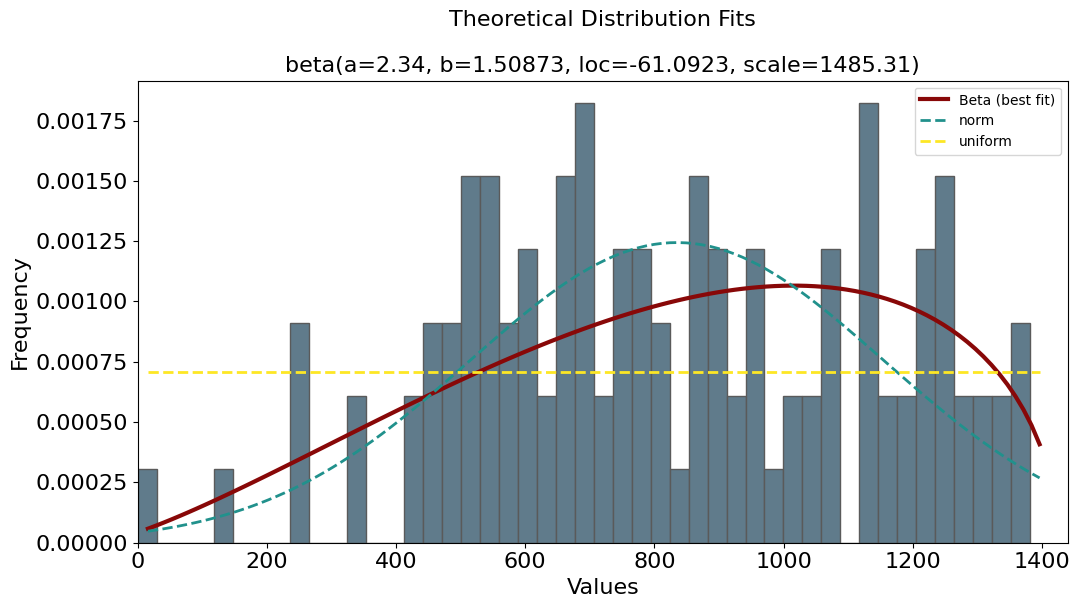

In [94]:
import numpy as np
# Count the logins for each interval for weekends
login_intervals_df = pd.DataFrame(columns=["IntervalStart", "LoginCount"])
login_intervals_df.loc[:, "IntervalStart"] = [i for i in range(0, 24*60, 30)]
login_intervals_df.loc[:, "LoginCount"] = 0
login_intervals_df["LoginCount"] = login_intervals_df["LoginCount"].astype(dtype="int64")
for loginTime in login_datetime_df[(login_datetime_df["DayName"] == "Saturday") | (login_datetime_df["DayName"] == "Sunday")]["TimeInMinutes"]:
    intervalIdx = loginTime // 30
    login_intervals_df.loc[intervalIdx, "LoginCount"] += 1
 
# Create a list of appearances of each interval
X = []
for idx in range(len(login_intervals_df)):
    X += [login_intervals_df.loc[idx, "IntervalStart"] + 1] * login_intervals_df.loc[idx, "LoginCount"]
if 1 not in X:
    X.append(1)
if 1411 not in X:
    X.append(1411)
X = pd.Series(X)

# Create the model for normal and uniform distributions
dfit = distfit(distr=["beta", "norm", "uniform"], bins=48, verbose=0)  # Initialize 
dfit.fit_transform(X)   # Fit distributions on empirical data X

# Results
if dfit.model["name"] == "norm":
    print("The data fits best to normal distribution with a score of", dfit.model["score"])
else:
    print("The data fits best to uniform distribution with a score of", dfit.model["score"])

# Plot the pdf
fig, ax = plt.subplots(figsize=(12, 6))
plot = dfit.plot(title="Theoretical Distribution Fits\n" , cmap="viridis", cii_properties=None, emp_properties=None, n_top=100, grid=False, xlim=(0, 1440), fig=fig, ax=ax)
fig.savefig("figures/login_times/weekends_pdf_fit.png")
plt.show()